## Feature Extraction (CNN) and similarity

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
import matplotlib.pyplot as plt

from scipy import ndimage 

import os
import cv2
import pandas as pd
%matplotlib inline

In [2]:
#Load the coordinates data set
df = pd.read_csv('train.csv')

In [3]:
# Load images and resize 
root= './train'
names = []
train_crude = []
for file in os.listdir(root):
    img = cv2.imread(os.path.join(root, file))#,cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (img.shape[1]//3,img.shape[0]//3))
    train_crude.append(img)
    names.append(file.split('.')[0])
    
data = np.stack( train_crude, axis=0 )

In [4]:
del train_crude

In [4]:
data.shape

(7500, 163, 226, 3)

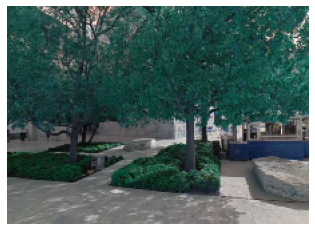

In [5]:
plt.imshow(data[0], cmap='gray')  
plt.title('')
plt.axis('off')
plt.show()

### Extract Features

In [19]:
#get features in batches and flatten
def get_features(base_model, preprocess_input, data):
    feat = []
    for i in range(0,7500,500):
        temp = base_model.predict(preprocess_input(data[i:i+500]))
        feat.append(temp)

    feat0 = np.concatenate(feat, axis=0) 
    feat2 = [i.ravel() for i in feat0]
    return np.stack(feat2, axis=0)
    

    
def get_neighbors(feat):
    from sklearn.neighbors import NearestNeighbors
    from sklearn.preprocessing import MinMaxScaler
    #scaler = MinMaxScaler()
    
    train = feat[:7000]
    test = feat[7000:]
    
    #train = scaler.fit_transform(train)
    #test = scaler.transform(test)

    neighTest = NearestNeighbors(n_neighbors = 5)
    neighTest.fit(train)

    neighbors_list = neighTest.kneighbors(test)
    
    return neighbors_list

def evaluate_similarity(df, neighbors_list, k = -1):
    evaluation = []
    for ix, pred in enumerate(neighbors_list[1]):
        x = df.x.iloc[ix+7000]
        y = df.y.iloc[ix+7000]
        distance = 0
        for p in pred[:k]:
            x0 = df.x.iloc[p]
            y0 = df.y.iloc[p]
            distance += np.sqrt((x - x0)**2 + (y - y0)**2)
        distance = distance / k
        evaluation.append(distance)
        
    return np.mean(evaluation)
    

#### Color histogram

In [21]:
colorVect = []
binSize = 32
for img in data:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    hist = cv2.calcHist([img], [0, 1, 2], None, [binSize, binSize, binSize],
            [0, 256, 0, 256, 0, 256])
    vect = cv2.normalize(hist, hist).flatten()
    colorVect.append(vect)

color_neigh = get_neighbors(colorVect)

In [32]:
for k in range(1, 6):
    print(evaluate_similarity(df, color_neigh, k))

28.581637088759198
32.09016612320682
35.07722318754523
36.42339622304142
37.17476602686389


In [33]:
from sklearn.neighbors import KNeighborsRegressor
neighReg0 = KNeighborsRegressor(n_neighbors=1, metric = 'euclidean', weights='distance')
neighReg0.fit(colorVect[:7000], df[['x','y']].iloc[:7000])
predictReg0 = neighReg0.predict(colorVect[7000:])

In [34]:
y_true = df[['x','y']].iloc[7000:]
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_true, predictReg0, multioutput='uniform_average')

18.833499999865012

#### CNN transfer learning

In [22]:
import tensorflow.keras.applications.resnet_v2 as resnet# preprocess_input #,resnet_v2.decode_predictions
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
resnet_model = ResNet50V2(weights='imagenet',input_shape=[163, 226,3],include_top=False,pooling= 'avg')

In [23]:
res_feat = get_features(resnet_model, resnet.preprocess_input, data)
res_neighs = get_neighbors(res_feat)

for k in range(1, 6):
    print(evaluate_similarity(df, res_neighs, k))

27.202903140076078
31.95138038965823
34.380541360274435
35.7838847716486
38.12195459693497


In [24]:
import tensorflow.keras.applications.xception as xception #.preprocess_input#, xception.decode_predictions
from tensorflow.keras.applications.xception import Xception
xception_model = Xception(weights='imagenet',input_shape=[163, 226,3],include_top=False, pooling= 'avg')

In [25]:
xcept_feat = get_features(xception_model,xception.preprocess_input, data)
xcept_neighs = get_neighbors(xcept_feat)

for k in range(1, 6):
    print(evaluate_similarity(df, xcept_neighs, k))

31.211483604242314
34.80481780601402
36.87977014376095
39.033750994824935
40.90234661016481


In [7]:
import tensorflow.keras.applications.efficientnet as effNet #.preprocess_input#, xception.decode_predictions
from tensorflow.keras.applications.efficientnet import EfficientNetB5
eNet_model = EfficientNetB5(weights='imagenet',input_shape=[163, 226,3],include_top=False, pooling= 'avg')

In [10]:
enet_feat = get_features(eNet_model,effNet.preprocess_input, data)
enet_neighs = get_neighbors(enet_feat)

for k in range(1, 6):
    print(evaluate_similarity(df, enet_neighs, k))

26.107781476145412
30.738023419585492
34.18996012095108
36.629624702099264
38.25847844737755


In [12]:
from sklearn.neighbors import KNeighborsRegressor
neighReg0 = KNeighborsRegressor(n_neighbors=1, metric = 'euclidean', weights='distance')
neighReg0.fit(enet_feat[:7000], df[['x','y']].iloc[:7000])
predictReg0 = neighReg0.predict(enet_feat[7000:])

y_true = df[['x','y']].iloc[7000:]
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_true, predictReg0, multioutput='uniform_average')

16.888600000532

In [13]:
from sklearn.linear_model import ElasticNet

en = ElasticNet()
en.fit(enet_feat[:7000], df[['x','y']].iloc[:7000])
predictEN = en.predict(enet_feat[7000:])

y_true = df[['x','y']].iloc[7000:]
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_true, predictEN, multioutput='uniform_average')

33.92864531541562

#### 100% SIFT MATCH

In [15]:
def extract_sift(data):
    
    sift = cv2.SIFT_create()
    sift_feat = []
    for img in data:
        kp, dsc = sift.detectAndCompute(img,None)
        sift_feat.append((kp,dsc))
    return sift_feat

def sift_matcher(pair1, pair2, flann):
    kp1, des1 = pair1
    kp2, des2 = pair2

    try:
        matches = flann.knnMatch(des1, des2, k = 2)
    except:
        return 0, None, None

    # Store all good matches as per Lowe's Ratio test.
    ratio = 0.6
    num_matches = 0
    ptsL = []
    ptsR = []
    for m,n in matches:
        if m.distance < ratio * n.distance:
            num_matches += 1
            ptsL.append(kp1[m.queryIdx].pt)
            ptsR.append(kp2[m.trainIdx].pt)
            
    ptsL = np.int32(ptsL)
    ptsR = np.int32(ptsR)
    
    return num_matches, ptsL, ptsR

def k_nearnest_candidate(train, test, k = 5):
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50)   # or pass empty dictionary
    flann = cv2.FlannBasedMatcher(index_params,search_params)
    knc = []
    for instance in test:
        k_candidate = []
        for ix, cand in enumerate(train):
            n, pt1, pt2 = sift_matcher(instance, cand, flann)
            if n > 0:
                k_candidate.append((n, pt1, pt2, ix))
        if len(k_candidate) > 0:
            k_candidate.sort(key = lambda x: x[0], reverse = True)
            knc.append(k_candidate[:k])
        else:
            knc.append([])
    return knc



In [17]:
%%time
sift_feat = extract_sift(data)
strain = sift_feat[:7000]
svalidation = sift_feat[7000:]
sift_nc = k_nearnest_candidate(strain, svalidation[:100])

Wall time: 1h 31min 43s


In [20]:
sift_neighs = [[j[3] for j in i] for i in sift_nc]
sift_neighs = [[],sift_neighs]

for k in range(1, 6):
    print(evaluate_similarity(df, sift_neighs, k))

22.58920763720541
26.481564889216948
28.699946397674218
30.712488293121847
32.00727790447606


In [ ]:
from sklearn.neighbors import KNeighborsRegressor
neighReg0 = KNeighborsRegressor(n_neighbors=1, metric = 'euclidean', weights='distance')
neighReg0.fit(enet_feat[:7000], df[['x','y']].iloc[:7000])
predictReg0 = neighReg0.predict(enet_feat[7000:])

y_true = df[['x','y']].iloc[7000:]
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_true, predictReg0, multioutput='uniform_average')

### Visualise Nearest neighbors

In [55]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=6)
neigh.fit(feat2)

NearestNeighbors(n_neighbors=6)

In [25]:
enet_neighs[1][0]

array([4737, 4435, 5878, 2964, 6559], dtype=int64)

<AxesSubplot:xlabel='x', ylabel='y'>

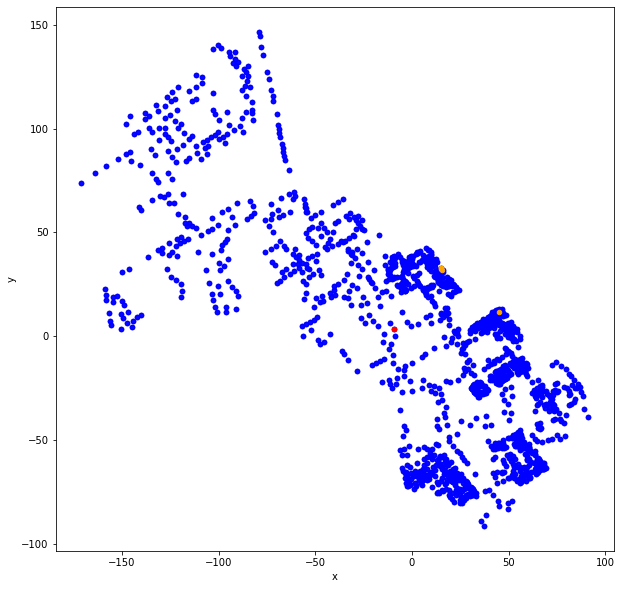

In [39]:
example = 1
#nn = neigh.kneighbors(np.expand_dims(feat2[example], axis=0))
predictions = enet_neighs[1][example]
#predictions = nn[1].tolist()[0]

original = df.iloc[example:example+1]
sample = df.iloc[predictions]
controls = df
ax = controls.plot(kind='scatter',x='x',y='y',figsize=(10,10), color='blue', alpha=0.5)
ax2 = sample.plot(ax=ax, kind='scatter',x='x',y='y',figsize=(10,10), color='orange')
original.plot(ax=ax2, kind='scatter',x='x',y='y',figsize=(10,10), color='red')


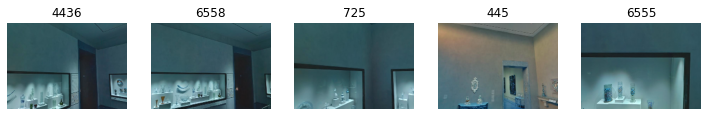

In [40]:
plt.subplots(figsize=(15,15))
for ix,im in enumerate(predictions):
    toShow = data[im]
    plt.subplot(1,6,ix+1)
    plt.imshow(toShow, cmap='gray')  
    plt.title(im)
    plt.axis('off')
plt.show()

##### Evaluate predict closest neighbour with averga

In [58]:
# calculate absolute error
train = feat2[:7001]
test = feat2[7001:]

neighTest = NearestNeighbors(n_neighbors=5)
neighTest.fit(train)

predict = neighTest.kneighbors(test)

In [64]:
nn[0]

array([[5.3947965e-06, 3.6004791e+02, 4.0566992e+02, 4.3347540e+02,
        4.3572549e+02, 4.3671918e+02]], dtype=float32)

In [59]:
#Pseudo prediction by average closest neighbours
#It turns out it works as KNN regressor, but here I can set a similarity quality threshhold.
threshold_distance = 950
result = []
for ix, instance in enumerate(predict[1]):
    x = []
    y = []
    for n, i in enumerate(instance):
        #if no neighbour passes the thresthold, use just the most similar, which is always the first
        if n in [0] or predict[0][ix][n] < threshold_distance:    
            x.append(df.iloc[i].x)
            y.append(df.iloc[i].y)

    result.append([sum(x)/len(x),sum(y)/len(y)])
        

In [60]:
y_true = df[['x','y']].iloc[7001:]
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_true, result, multioutput='uniform_average')

34.21855711472828

### Using regression to predic

##### KNN regression version

In [297]:
from sklearn.model_selection import GridSearchCV

parameters = {'metric':('euclidean', 'manhattan','chebyshev'),#'algorithm':('ball_tree', 'kd_tree', 'brute')
              'weights':('uniform', 'distance'), 'n_neighbors': [3,5,7]}
knn = KNeighborsRegressor(n_jobs=-1)
clf = GridSearchCV(knn, parameters, scoring='neg_mean_absolute_error')
clf.fit(feat2[:7001], df[['x','y']].iloc[:7001])

print(clf.best_score_)
clf.best_params_

-34.08494689289202


{'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}

In [61]:
from sklearn.neighbors import KNeighborsRegressor
neighReg0 = KNeighborsRegressor(n_neighbors=3, metric = 'euclidean', weights='distance')
neighReg0.fit(feat2[:7001], df[['x','y']].iloc[:7001])
predictReg0 = neighReg0.predict(feat2[7001:])

y_true = df[['x','y']].iloc[7001:]
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_true, predictReg0, multioutput='uniform_average')

32.0813379648212

##### Simple regression

In [65]:
from sklearn.linear_model import ElasticNet

en = ElasticNet()
en.fit(feat2[:7001], df[['x','y']].iloc[:7001])
predictEN = en.predict(feat2[7001:])

y_true = df[['x','y']].iloc[7001:]
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_true, predictEN, multioutput='uniform_average')

C:\Users\framo\.conda\envs\CV\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17434.93359375, tolerance: 2411.36669921875
  positive)
C:\Users\framo\.conda\envs\CV\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28758.6875, tolerance: 1836.829345703125
  positive)


26.803386073022153

In [68]:
"""
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(criterion = 'mae',max_depth =20, n_estimators = 10)
rfr.fit(feat2[:7001], df[['x','y']].iloc[:7001])
predictRFR = rfr.predict(feat2[7001:])

y_true = df[['x','y']].iloc[7001:]
mean_absolute_error(y_true, predictRFR, multioutput='uniform_average')
"""

"\nfrom sklearn.ensemble import RandomForestRegressor\n\nrfr = RandomForestRegressor(criterion = 'mae',max_depth =20, n_estimators = 10)\nrfr.fit(feat2[:7001], df[['x','y']].iloc[:7001])\npredictRFR = rfr.predict(feat2[7001:])\n\ny_true = df[['x','y']].iloc[7001:]\nmean_absolute_error(y_true, predictRFR, multioutput='uniform_average')\n"

In [309]:
from sklearn.linear_model import Ridge

rfr = Ridge()
rfr.fit(feat2[:7001], df[['x','y']].iloc[:7001])
predictRFR = rfr.predict(feat2[7001:])

y_true = df[['x','y']].iloc[7001:]
mean_absolute_error(y_true, predictRFR, multioutput='uniform_average')

C:\Users\framo\.conda\envs\CV\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


48.708598873886075

##### full CNN

In [23]:
np.array(colorVect).shape

(7500, 32768)

In [15]:
model3 = keras.Sequential(
    [
        layers.InputLayer((2048,)),
        #layers.Flatten(),
        #layers.GlobalAveragePooling2D(),
        layers.Dense(1024, activation='relu'),
        layers.Dense(512, activation='relu'),
        layers.Dense(256, activation='relu'),
        #layers.Dropout(0.25),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(16, activation='relu'),
        layers.Dense(8, activation='relu'),
        layers.Dense(4, activation='relu'),
        layers.Dense(2)
    ], 
)
opt = keras.optimizers.Adam(learning_rate=0.001)
model3.compile(optimizer=opt,
            loss=tf.keras.losses.MeanAbsoluteError(),
            metrics=['mae'])

In [16]:
model3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 1

In [20]:
cls4=model3.fit(enet_feat[:7000], df[['x','y']].iloc[:7000], validation_data=(enet_feat[7000:],df[['x','y']].iloc[7000:]),epochs=40, batch_size=32)

Epoch 1/40
219/219 [==============================] - 1s 6ms/step - loss: 2.3705 - mae: 2.3705 - val_loss: 14.2124 - val_mae: 14.2124
Epoch 2/40
219/219 [==============================] - 1s 7ms/step - loss: 2.2524 - mae: 2.2524 - val_loss: 14.9700 - val_mae: 14.9700
Epoch 3/40
219/219 [==============================] - 1s 7ms/step - loss: 2.2431 - mae: 2.2431 - val_loss: 14.4327 - val_mae: 14.4327
Epoch 4/40
219/219 [==============================] - 1s 6ms/step - loss: 2.1966 - mae: 2.1966 - val_loss: 14.8719 - val_mae: 14.8719
Epoch 5/40
219/219 [==============================] - 1s 6ms/step - loss: 2.1744 - mae: 2.1744 - val_loss: 14.2875 - val_mae: 14.2875
Epoch 6/40
219/219 [==============================] - 1s 6ms/step - loss: 2.1831 - mae: 2.1831 - val_loss: 14.5874 - val_mae: 14.5874
Epoch 7/40
219/219 [==============================] - 1s 7ms/step - loss: 2.1315 - mae: 2.1315 - val_loss: 14.9944 - val_mae: 14.9944
Epoch 8/40
219/219 [==============================] - 1s 7ms/s

In [101]:
model3.save('transCNN14')

INFO:tensorflow:Assets written to: transCNN14\assets


##### to test

In [87]:
oot= './test'
names_id = []
test_matrix = []
for file in os.listdir(root):
    img = cv2.imread(os.path.join(root, file))#,cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (226, 163))
    test_matrix.append(img)
    names_id.append(file.split('.')[0])

test_data = np.stack( test_matrix, axis=0 )


In [88]:
data.shape

(7500, 163, 226, 3)

In [89]:
test_data.shape

(1200, 163, 226, 3)

In [103]:
feat_test = []
for i in range(0,test_data.shape[0],10):
    temp = base_model.predict(preprocess_input(test_data[i:i+10]))
    #print('round: '+i)
    feat_test.append(temp)

feat_test = np.concatenate(feat_test, axis=0)
feat_test.shape

(1200, 6, 8, 2048)

In [105]:
cnn_features_test = model3.predict(feat_test)

df_test = pd.read_csv('imagenames.csv')
df_test = pd.concat([df_test,pd.DataFrame(cnn_features_test, columns=['x','y'])], axis=1)
df_test.to_csv('CNNPredition', index=False)

### AUTOENCODER

Autoencoder need to avoid odd number divisions as they are floored, then in the decoder part cannot go back to the original size.
Therefore, image size must be divisible

In [4]:
#reload data in a fitting size for the autoencoder to de code(no inexact divisions)

root= './train'
names = []
train_crude = []
for file in os.listdir(root):
    img = cv2.imread(os.path.join(root, file))#,cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (360,280))
    train_crude.append(img)
    names.append(file.split('.')[0])

data = np.stack( train_crude, axis=0 )

In [5]:
data[0].shape

(280, 360, 3)

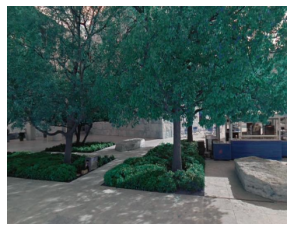

In [6]:
plt.imshow(data[0])#, cmap='gray')  
plt.title('')
plt.axis('off')
plt.show()

In [13]:
input_img = keras.Input(shape=(280, 360,3))

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(4, (2, 2), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = layers.Conv2D(4, (2, 2), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [14]:
autoencoder.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 280, 360, 3)]     0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 280, 360, 16)      448       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 140, 180, 16)      0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 140, 180, 8)       1160      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 70, 90, 8)         0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 70, 90, 8)         584       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 35, 45, 8)         0   

In [220]:

autoencoder.fit(data[:7000], data[:7000],
                epochs=20,
                batch_size=64,
                shuffle=True,
                validation_data=(data[7000:], data[7000:]))

Epoch 1/50
110/110 [==============================] - 52s 402ms/step - loss: -1767.9202 - val_loss: -1808.7229
Epoch 2/50
110/110 [==============================] - 41s 371ms/step - loss: -1800.5150 - val_loss: -1808.7229
Epoch 3/50
110/110 [==============================] - 41s 377ms/step - loss: -1800.5148 - val_loss: -1808.7230
Epoch 4/50
110/110 [==============================] - 41s 373ms/step - loss: -1800.5148 - val_loss: -1808.7230
Epoch 5/50
110/110 [==============================] - 41s 371ms/step - loss: -1800.5153 - val_loss: -1808.7230
Epoch 6/50
110/110 [==============================] - 41s 371ms/step - loss: -1800.5148 - val_loss: -1808.7230
Epoch 7/50
110/110 [==============================] - 41s 370ms/step - loss: -1800.5151 - val_loss: -1808.7230
Epoch 8/50
110/110 [==============================] - 41s 375ms/step - loss: -1800.5148 - val_loss: -1808.7230
Epoch 9/50
110/110 [==============================] - 41s 375ms/step - loss: -1800.5149 - val_loss: -1808.7230
E

In [221]:
encoder = keras.Model(input_img, encoded)

In [235]:
encoder_features = encoder.predict(data)
encoder_features = [i.ravel() for i in encoder_features]
encoder_features = np.stack(encoder_features, axis=0)

In [237]:
encoder_features.shape

(7500, 12600)

In [239]:
from sklearn.neighbors import KNeighborsRegressor

neighReg = KNeighborsRegressor(n_neighbors=5)
neighReg.fit(encoder_features[:7000], df[['x','y']].iloc[:7000])
predictReg = neighReg.predict(encoder_features[7000:])

y_true = df[['x','y']].iloc[7000:]
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_true, predictReg, multioutput='uniform_average')

39.219920000567825

In [257]:
from sklearn.model_selection import GridSearchCV

parameters = {'metric':('euclidean', 'manhattan','chebyshev'),#'algorithm':('ball_tree', 'kd_tree', 'brute')
              'weights':('uniform', 'distance'), 'n_neighbors': [1,2,3,5,10],'n_jobs': [4]}
knn = KNeighborsRegressor()
clf = GridSearchCV(knn, parameters, scoring='neg_mean_absolute_error')
clf.fit(encoder_features[:7000], df[['x','y']].iloc[:7000])

print(clf.best_score_)
clf.best_params_

-37.03590577893906


{'metric': 'manhattan', 'n_jobs': 4, 'n_neighbors': 10, 'weights': 'distance'}

In [281]:
pd.DataFrame(clf.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_metric,param_n_jobs,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.213217,0.017659,5.030996,0.423176,euclidean,4,1,uniform,"{'metric': 'euclidean', 'n_jobs': 4, 'n_neighb...",-47.018750,-47.555214,-48.073714,-48.786571,-46.479679,-47.582786,0.803225,25
1,0.197610,0.006348,4.564031,0.086157,euclidean,4,1,distance,"{'metric': 'euclidean', 'n_jobs': 4, 'n_neighb...",-47.018750,-47.555214,-48.073714,-48.786571,-46.479679,-47.582786,0.803225,25
2,0.196416,0.004508,4.513096,0.104750,euclidean,4,2,uniform,"{'metric': 'euclidean', 'n_jobs': 4, 'n_neighb...",-42.756161,-42.823589,-44.274268,-44.944911,-43.063982,-43.572582,0.878847,20
3,0.213009,0.015812,4.950998,0.326221,euclidean,4,2,distance,"{'metric': 'euclidean', 'n_jobs': 4, 'n_neighb...",-42.676606,-42.751364,-44.169609,-44.846863,-43.005243,-43.489937,0.865463,19
4,0.216995,0.008652,4.498116,0.112401,euclidean,4,3,uniform,"{'metric': 'euclidean', 'n_jobs': 4, 'n_neighb...",-41.223071,-41.077810,-42.929595,-43.135095,-41.449702,-41.963055,0.883475,14
5,0.208402,0.001356,4.487600,0.054375,euclidean,4,3,distance,"{'metric': 'euclidean', 'n_jobs': 4, 'n_neighb...",-41.147340,-40.980152,-42.848500,-43.040543,-41.390511,-41.881409,0.879882,13
6,0.202649,0.003431,4.515605,0.056479,euclidean,4,5,uniform,"{'metric': 'euclidean', 'n_jobs': 4, 'n_neighb...",-40.012064,-39.956221,-41.518100,-41.402121,-39.687479,-40.515197,0.780149,12
7,0.206982,0.008607,4.505409,0.078060,euclidean,4,5,distance,"{'metric': 'euclidean', 'n_jobs': 4, 'n_neighb...",-39.951656,-39.862734,-41.437735,-41.324903,-39.630182,-40.441442,0.775376,11
8,0.207402,0.004123,4.523387,0.036781,euclidean,4,10,uniform,"{'metric': 'euclidean', 'n_jobs': 4, 'n_neighb...",-38.863493,-38.884943,-40.334779,-40.269457,-38.898425,-39.450219,0.695968,8
9,0.208801,0.003249,4.551638,0.017008,euclidean,4,10,distance,"{'metric': 'euclidean', 'n_jobs': 4, 'n_neighb...",-38.818635,-38.790535,-40.269245,-40.211524,-38.848654,-39.387719,0.696681,7


In [250]:
neighReg2 = KNeighborsRegressor(n_neighbors=5, metric = 'manhattan', weights='distance')
neighReg2.fit(encoder_features[:7000], df[['x','y']].iloc[:7000])
predictReg = neighReg2.predict(encoder_features[7000:])

y_true = df[['x','y']].iloc[7000:]
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_true, predictReg, multioutput='uniform_average')

36.357381006532634

##### To test

In [3]:
#load test data
root= './test'
names_id = []
test_matrix = []
for file in os.listdir(root):
    img = cv2.imread(os.path.join(root, file),cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (360,280))
    test_matrix.append(img)
    names_id.append(file.split('.')[0])

test_data = np.stack( test_matrix, axis=0 )


In [245]:
encoder_features_test = base_model.predict(test_data)
encoder_features_test = [i.ravel() for i in encoder_features_test]
encoder_features_test = np.stack(encoder_features_test, axis=0)

In [247]:
neighReg = KNeighborsRegressor(n_neighbors=5, metric = 'manhattan', weights='distance')
neighReg.fit(encoder_features, df[['x','y']])


KNeighborsRegressor(metric='manhattan', weights='distance')

In [248]:
test_predict = neighReg.predict(encoder_features_test)


In [249]:
test_predict

array([[ 37.68485471, -34.72265119],
       [ 13.60803497,   0.14159319],
       [ 23.25119436, -33.94169914],
       ...,
       [-29.15136877,  24.36858111],
       [ 27.08772355, -73.94742896],
       [ 17.49124652,   2.84351708]])

In [258]:
df_test = pd.read_csv('imagenames.csv')
df_test = pd.concat([df_test,pd.DataFrame(test_predict, columns=['x','y'])], axis=1)
df_test.to_csv('simplePredition', index=False)

## Baseline score

In [290]:
baseline = np.array([[df.x.mean(), df.y.mean()]*499]).reshape(499,2)
mean_absolute_error(y_true, baseline, multioutput='uniform_average')

44.90939559213609